## Homework 01. Simple text processing.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

*Disclaimer: The used dataset may contain obscene language and is used only as an example of real unfiltered data.*

In [3]:
# In colab uncomment this cell
! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/homeworks/homework01/utils.py -nc

File ‘utils.py’ already there; not retrieving.



In [4]:
try:
    data = pd.read_csv('../../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

File ‘comments.tsv’ already there; not retrieving.



In [5]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [9]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [10]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [11]:
# task: preprocess each comment in train and test

texts_train = np.array(list(map(preprocess, texts_train)))
texts_test = np.array(list(map(preprocess, texts_test)))

In [11]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [13]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

from collections import defaultdict
vocab = defaultdict(int)
for text in texts_train:
    splitted_text = text.split()
    for string in splitted_text:
        vocab[string] += 1
bow_vocabulary = list({k: v for k, v in sorted(vocab.items(), key=lambda x: x[1], reverse=True)}.keys())[:k]

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', '←']


In [14]:
def text_to_bow(text, vocabulary):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    output = np.zeros(len(vocabulary), dtype="float32")
    for word in text.split():
        try:
            output[vocabulary.index(word)] += 1
        except ValueError as e:
            continue
    return output


In [16]:
X_train_bow = np.stack(list(map(lambda x: text_to_bow(x, bow_vocabulary), texts_train)))
X_test_bow = np.stack(list(map(lambda x: text_to_bow(x, bow_vocabulary), texts_test)))

In [17]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [18]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

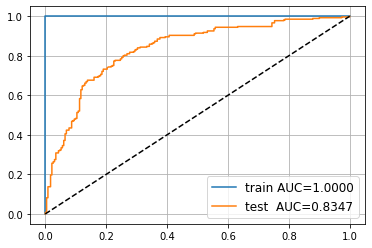

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [22]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [23]:
from utils import plot_train_process

In [24]:
model = nn.Sequential()

model.add_module("l1", nn.Linear(in_features=len(bow_vocabulary), out_features=2))

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [25]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

In [26]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [27]:
X_train_bow_torch = torch.FloatTensor(X_train_bow)
X_test_bow_torch = torch.FloatTensor(X_test_bow)

y_train_torch = torch.LongTensor(y_train)
y_test_torch = torch.LongTensor(y_test)

Let's test that everything is fine

In [28]:
# example loss
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

In [29]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [736]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10,
    device="cpu"
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    
    model.to(device)
    X_val_torch = X_val_torch.to(device)
    y_val_torch = y_val_torch.to(device)
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix].to(device)
        y_batch = y_train_torch[ix].to(device)

        opt.zero_grad()
        # predict log-probabilities or logits
        y_predicted = model(x_batch)

        # compute loss, just like before
        ### YOUR CODE
#         print(y_predicted)
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        ### YOUR CODE
        loss.backward()
        
        # Adam step
        ### YOUR CODE
        opt.step()

        # clear gradients
        ### YOUR CODE

        local_train_loss_history.append(loss.cpu().detach().data.numpy())
        loss = loss.to(device)
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

In [31]:
lr_scheduler = ReduceLROnPlateau(optimizer=opt)

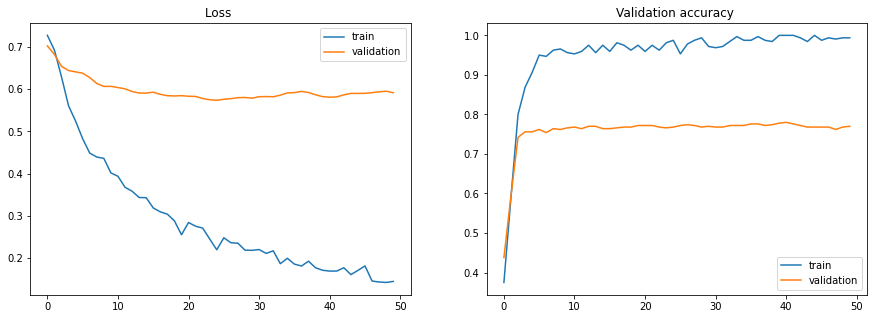

Sequential(
  (l1): Linear(in_features=5707, out_features=2, bias=True)
)

In [32]:
train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

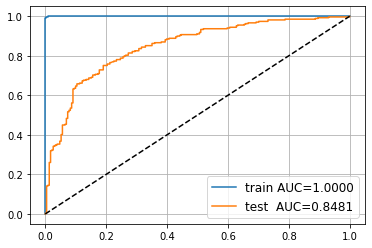

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model),
    ('test ', X_test_bow_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

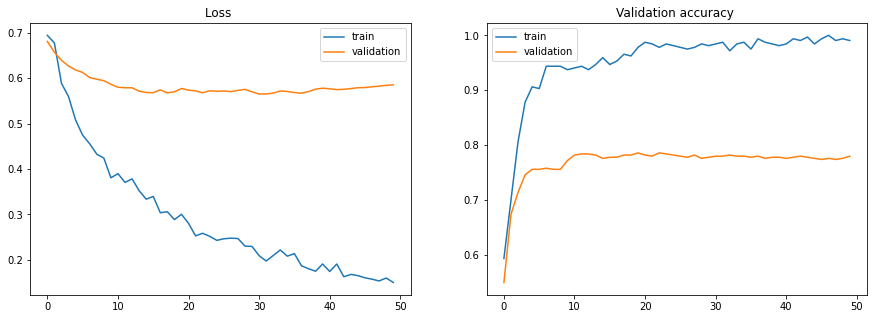

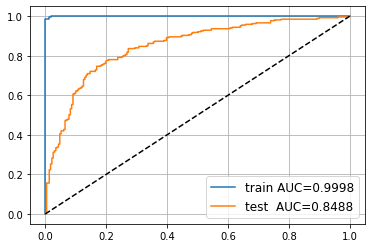

In [35]:
train_aucs, test_aucs = [], []
for k in range(1000, 5001, 1000):
    bow_vocabulary_k = list({k: v for k, v in sorted(vocab.items(), key=lambda x: x[1], reverse=True)}.keys())[:k]
    X_train_bow = np.stack(list(map(lambda x: text_to_bow(text=x, vocabulary=bow_vocabulary_k), texts_train)))
    X_test_bow = np.stack(list(map(lambda x: text_to_bow(text=x, vocabulary=bow_vocabulary_k), texts_test)))
    X_train_bow_torch = torch.FloatTensor(X_train_bow)
    X_test_bow_torch = torch.FloatTensor(X_test_bow)
    model_with_k = nn.Sequential()
    model_with_k.add_module("l1", nn.Linear(in_features=k, out_features=2))
    opt = torch.optim.Adam(model_with_k.parameters(), lr=1e-3)
    lr_scheduler = ReduceLROnPlateau(optimizer=opt)
    train_model(model_with_k, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)
    for name, X, y, model_with_k in [
        ('train', X_train_bow_torch, y_train, model_with_k),
        ('test ', X_test_bow_torch, y_test, model_with_k)
    ]:
        proba = model_with_k(X).detach().cpu().numpy()[:, 1]
        auc = roc_auc_score(y, proba)
        if name == 'train':
            train_aucs.append(auc)
        else:
            test_aucs.append(auc)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.grid()

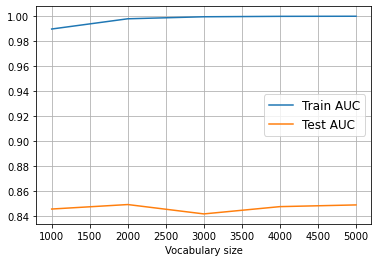

In [36]:
plt.plot(range(1000, 5001, 1000), train_aucs, label='Train AUC')
plt.plot(range(1000, 5001, 1000), test_aucs, label='Test AUC')
plt.xlabel("Vocabulary size")
plt.legend(fontsize='large')
plt.grid()

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [37]:
compliance = {word: idx for idx, word in enumerate(vocab.keys())}

In [168]:
from collections import defaultdict
def get_tf_idf(text, word_to_number, alpha=1):
    tf_map = np.empty((0, len(word_to_number)), dtype="float32")
    word_occurences = np.zeros(len(word_to_number), dtype="int32")
    word_occurences_dict = defaultdict(set)
    for idx, line in enumerate(text):
        tf_map_cur = np.zeros(len(word_to_number))
        splitted_line = line.split()
        for word in splitted_line:
            try:
                tf_map_cur[word_to_number[word]] += 1
                word_occurences_dict[word].add(idx)
            except KeyError as e:
                continue
        tf_map_cur = np.array(list(map(lambda x: x / len(tf_map_cur), tf_map_cur)))
        tf_map = np.vstack((tf_map, tf_map_cur))
    for word in word_occurences_dict.keys():
        try:
            word_occurences[word_to_number[word]] = len(word_occurences_dict[word])
        except KeyError as e:
            continue
    idf_scores = np.array(list(map(lambda cnt: np.log(len(text) / (cnt + alpha)), word_occurences)))
    return tf_map * idf_scores, tf_map, idf_scores

In [169]:
%%time
tf_idf_map_train, tf_map_train, idf_scores_train = get_tf_idf(texts_train, compliance)
tf_idf_map_test, tf_map_test, idf_scores_test = get_tf_idf(texts_test, compliance)

CPU times: user 2.96 s, sys: 3.66 ms, total: 2.97 s
Wall time: 2.97 s


In [173]:
from sklearn.feature_extraction.text import TfidfVectorizer
sklearn_tf_idf = TfidfVectorizer(vocabulary=compliance, token_pattern=r"\S+")

In [174]:
sklearn_tf_idf.fit_transform(texts_train).todense()

matrix([[0.20296806, 0.28045429, 0.10644832, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02862653, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.08191632, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.44569661, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.30460329,
         0.30460329]])

In [177]:
tf_idf_map_train

array([[0.00041431, 0.00063951, 0.0001338 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0001338 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00026759, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03386212, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00096749,
        0.00096749]])

In [178]:
from sklearn.preprocessing import normalize
tf_idf_map_train_normalized = normalize(tf_idf_map_train, norm="l2")
tf_idf_map_test_normalized = normalize(tf_idf_map_test, norm="l2")

Same stuff about moel and optimizers here (or just omit it, if you are using the same model as before).

In [179]:
X_train_tfidf_torch = torch.FloatTensor(tf_idf_map_train_normalized)
X_test_tfidf_torch = torch.FloatTensor(tf_idf_map_test_normalized)

# y_train_torch = ### YOUR CODE HERE
# y_test_torch = ### YOUR CODE HERE

In [117]:
X_train_tfidf_torch

tensor([[ 0.1201,  0.2684, -0.0285,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0084,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000, -0.0221,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.4861,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.3479,  0.3479]])

In [203]:
tf_idf_model = nn.Sequential()
tf_idf_model.add_module("l1", nn.Linear(in_features=X_train_tfidf_torch.shape[1], out_features=2))
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(tf_idf_model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(optimizer=opt, cooldown=10)

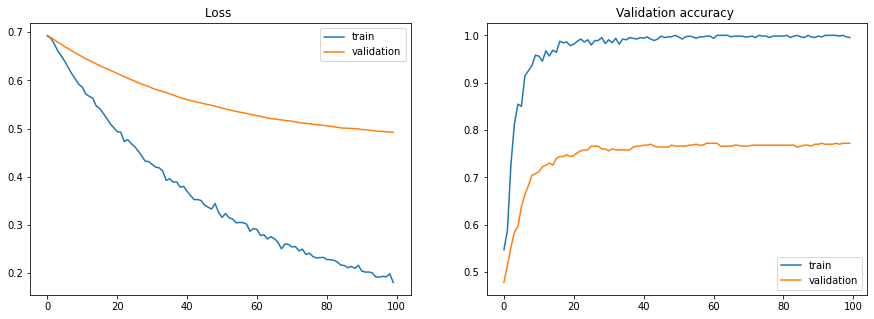

Sequential(
  (l1): Linear(in_features=5707, out_features=2, bias=True)
)

In [204]:
train_model(X_train_torch=X_train_tfidf_torch, X_val_torch=X_test_tfidf_torch, n_iterations=1000, batch_size=64,
            y_train_torch=y_train_torch, y_val_torch=y_test_torch,
            model=tf_idf_model, opt=opt, lr_scheduler=lr_scheduler)

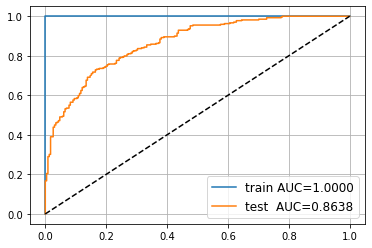

In [205]:
for name, X, y, model in [
    ('train', X_train_tfidf_torch, y_train, tf_idf_model),
    ('test ', X_test_tfidf_torch, y_test, tf_idf_model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    if name == 'train':
        train_aucs.append(auc)
    else:
        test_aucs.append(auc)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

In [187]:
from sklearn.naive_bayes import MultinomialNB
multinomialNB_bow = MultinomialNB()
multinomialNB_tf_idf = MultinomialNB()

In [197]:
multinomialNB_bow.fit(X=X_train_bow, y=y_train)
multinomialNB_tf_idf.fit(X=tf_idf_map_train_normalized, y=y_train)

MultinomialNB()

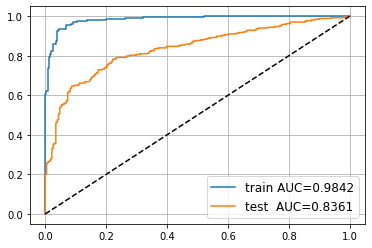

In [198]:
for name, X, y, model in [
    ('train', X_train_bow, y_train, multinomialNB_bow),
    ('test ', X_test_bow, y_test, multinomialNB_bow)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

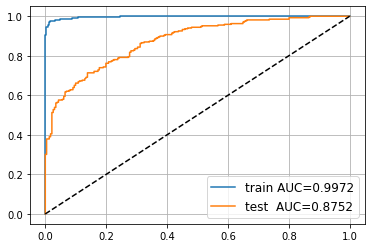

In [199]:
for name, X, y, model in [
    ('train', tf_idf_map_train_normalized, y_train, multinomialNB_tf_idf),
    ('test ', tf_idf_map_test_normalized, y_test, multinomialNB_tf_idf)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

Лучшее качество показал _MultinomialNB_ на нормализованных данных: 0.8752 test AUC. Для каждой модели нормализация по семплам увеличивала качество, т.е. как и логрег на торче показал качество большее на нормализованных данных, так и наивный байес. Также для всех рассмотренных моделей переход от BoW к TF-IDF показал увеличение качества. Увеличение _lr_ быстро приводило к переобучению, а изменение _lr_scheduler_ не сильно изменило качество.

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [526]:
import gensim.downloader as api
vec_size = 25
gensim_model = api.load('glove-twitter-' + str(vec_size))

[===========---------------------------------------] 22.4% 23.4/104.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 58.4% 61.2/104.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.0% 99.5/104.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [527]:
new_vocab = ["<UNK>", "<PAD>"]
for word in vocab:
    try:
        gensim_model.get_vector(word)
        new_vocab.append(word)
    except KeyError as e:
        continue
new_vocab = {word: idx for idx, word in enumerate(new_vocab)}

In [528]:
UNK_IX, PAD_IX = map(new_vocab.get, ["<UNK>", "<PAD>"])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [new_vocab.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [529]:
max_len = None
X_train_w2v = as_matrix(texts_train, max_len=max_len)
X_test_w2v = as_matrix(texts_test, max_len=max_len)

In [530]:
X_train_w2v_torch = torch.LongTensor(X_train_w2v)
X_test_w2v_torch = torch.LongTensor(X_test_w2v)

In [531]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

In [532]:
word2vec_emb_matrix = np.random.normal(size=(2, vec_size))
for word in new_vocab:
    try:
        word2vec_emb_matrix = np.vstack((word2vec_emb_matrix, gensim_model.get_vector(word)))
    except KeyError as e:
        continue
        
word2vec_emb_matrix = torch.FloatTensor(word2vec_emb_matrix)

In [533]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [829]:
n_tokens = len(new_vocab)
hid_size = vec_size
n_maximums = 3

simple_model = nn.Sequential()

simple_model.add_module('emb', nn.Embedding.from_pretrained(embeddings=word2vec_emb_matrix, padding_idx=PAD_IX, freeze=False))
simple_model.add_module('reorder', Reorder())
simple_model.add_module('conv1', nn.Conv1d(
    in_channels=hid_size,
    out_channels=hid_size,
    kernel_size=2
))
simple_model.add_module('bn1', nn.BatchNorm1d(hid_size))
# simple_model.add_module('conv2', nn.Conv1d(
#     in_channels=hid_size,
#     out_channels=hid_size,
#     kernel_size=3
# ))
# simple_model.add_module('relu2', nn.ReLU())
simple_model.add_module('adaptive_pool', nn.AdaptiveMaxPool1d(output_size=n_maximums))
simple_model.add_module('relu1', nn.ReLU())
simple_model.add_module('flatten', nn.Flatten())
simple_model.add_module('out', nn.Linear(in_features=hid_size*n_maximums, out_features=2))

In [830]:
simple_model.emb(X_train_w2v_torch[0]).shape

torch.Size([1247, 25])

In [831]:
loss_function = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
opt = torch.optim.Adam(simple_model.parameters(), lr=3e-3)
lr_scheduler = ReduceLROnPlateau(optimizer=opt, cooldown=7)

In [832]:
torch.cuda.empty_cache()

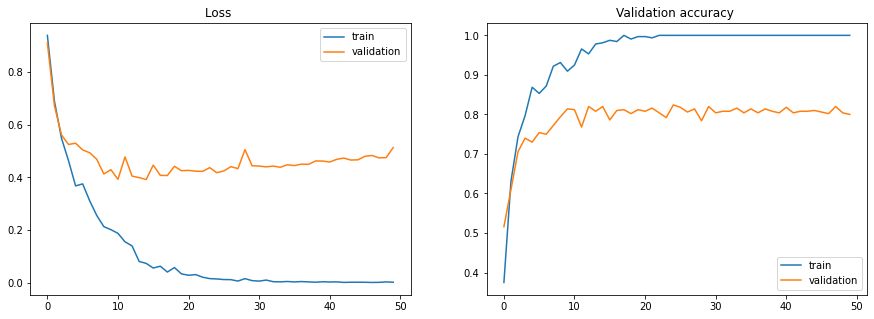

Sequential(
  (emb): Embedding(4806, 25, padding_idx=1)
  (reorder): Reorder()
  (conv1): Conv1d(25, 25, kernel_size=(2,), stride=(1,))
  (bn1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (adaptive_pool): AdaptiveMaxPool1d(output_size=3)
  (relu1): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=75, out_features=2, bias=True)
)

In [833]:
train_model(simple_model, opt, lr_scheduler, X_train_w2v_torch, y_train_torch, X_test_w2v_torch, y_test_torch, device=device, warm_start=True, n_iterations=500, batch_size=32)

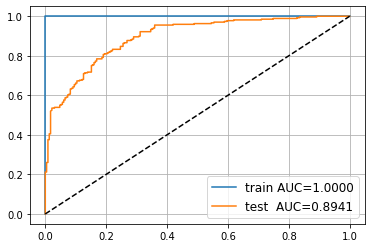

In [834]:
for name, X, y, model in [
    ('train', X_train_w2v_torch, y_train, simple_model),
    ('test ', X_test_w2v_torch, y_test, simple_model)
]:
    proba = model(X.to(device)).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()